# Analysis of the Cervical Cancer Dataser from CodeHerCare

This notebook contains step-by-step analysis of attributes that contribute to the risk of women developing cervical cancer.

Data source : CodeHerCare

Steps:

1. Understanding the data
2. Cleaning data
3. Feature Engineering 
4. Modelling
5. Testing
6. Deploying

Step 3, 4, 5 are iterative until we find the correct features for risk assessment

In [209]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for handling categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# libraries for normalization and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# libraries for model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score

# libraries for clustering
from sklearn.cluster import KMeans, DBSCAN

# libraries for dimensionality reduction
from sklearn.decomposition import PCA, TruncatedSVD

# libraries for model evaluation
from sklearn.metrics import silhouette_score

# suppress warningsimport warnings
import warnings
warnings.filterwarnings("ignore")

In [210]:
# load the dataset
cerv_data = 'data/Cervical Cancer Datasets_.xlsx'
cerv_df = pd.read_excel(cerv_data, sheet_name='Cervical Cancer Risk Factors')
cerv_df.head()

,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN


## Data Understanding

In [211]:
cerv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Patient ID                 100 non-null    object
 1   Age                        100 non-null    int64 
 2   Sexual Partners            100 non-null    int64 
 3   First Sexual Activity Age  100 non-null    int64 
 4   HPV Test Result            100 non-null    object
 5   Pap Smear Result           100 non-null    object
 6   Smoking Status             100 non-null    object
 7   STDs History               100 non-null    object
 8   Region                     100 non-null    object
 9   Insrance Covered           100 non-null    object
 10  Screening Type Last        100 non-null    object
 11  Recommended Action         100 non-null    object
 12  Unnamed: 12                1 non-null      object
dtypes: int64(3), object(10)
memory usage: 10.3+ KB


## Info

- there are 13 features in the dataset, each feature containing 100 instances
- 3 of the feature, `Age`, `Sexual Partners`, `First Sexual Activity Age`, are in numerical form and the rest of the feature are in categorical form
- The `unnamed: 12` columns contains 99 missing values, we will drop them
- The patient ID doesn't contribute much in this dataset

In [212]:
# statistical description
cerv_df.describe()

,Age,Sexual Partners,First Sexual Activity Age
count,100.000000,100.000000,100.000000
mean,37.430000,2.740000,18.830000
std,10.961139,1.432805,5.630105
min,15.000000,1.000000,2.000000
25%,34.000000,2.000000,16.000000
50%,36.000000,3.000000,18.000000
75%,40.000000,3.000000,20.000000
max,89.000000,9.000000,57.000000


## describe info

- `Age` - this features contains the different Ages of the patient
  - the mean age is 37
  - the deviation from the mean is 10, we will compare it with the mean (CV = 10/37 = 0.27027)
  - the minimum age is 15 years, the maximum age is 89 years

- `Sexual Partners` - this feature contains the number of number of sexual patners the patient has
  - the mean is 2 sexual partners
  - the deviation from the mean is 1.4
  - the minimum sexual partners is 1 and the maximum is 9

- `First Sexual Activity Age` - this feature contains the age when the patient had her first sexual intercourse
  - the mean is 18 years
  - the std is 5 years
  - and the min age is 2🤨, max age is 57 years

## Numerical Analysis

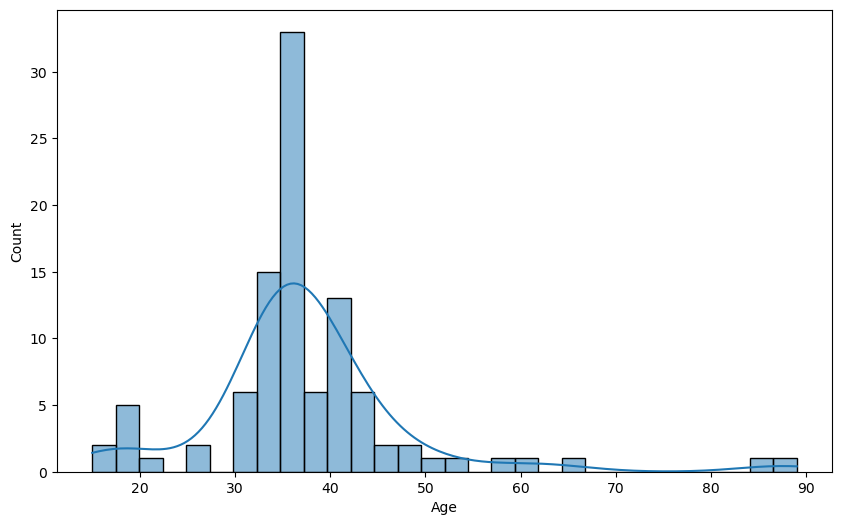

In [213]:
# Age
plt.figure(figsize=(10, 6))
sns.histplot(cerv_df['Age'], bins=30, kde=True);

Age: 
- Positively skewed with a long tail, majority of the patients in this dataset are between 34 and 44
- the older generation contribute to the long tail between 50 - 89
- this imbalance may cause the model to overfit

To be done:
- Normalization
- Binning

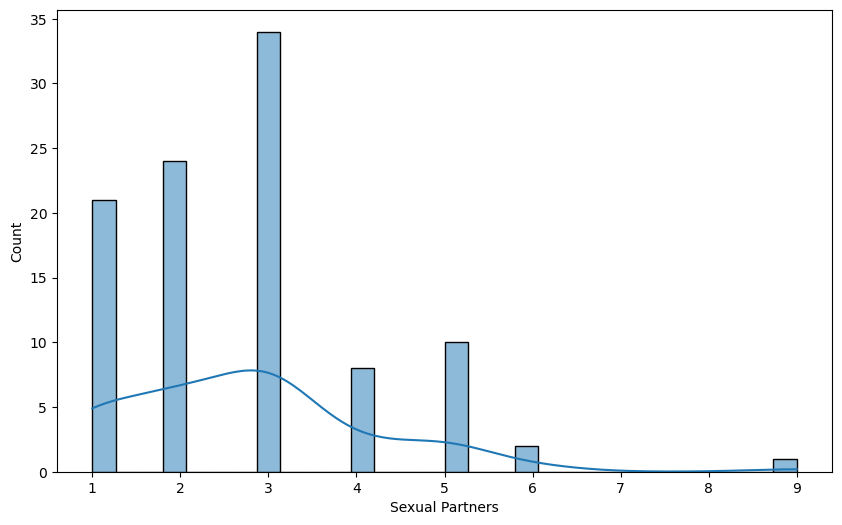

In [214]:
# sexual partners
plt.figure(figsize=(10, 6))
sns.histplot(cerv_df['Sexual Partners'], bins=30, kde=True);

Sexual Partners:
- Even thought there number of sexual partners are between 1 and 9, it will be a continuous variable (In the application, any value beyond 9 will be represented as 9 and a user cannot enter a negative vaule)

To do:
- Normalization (min-max scaling)

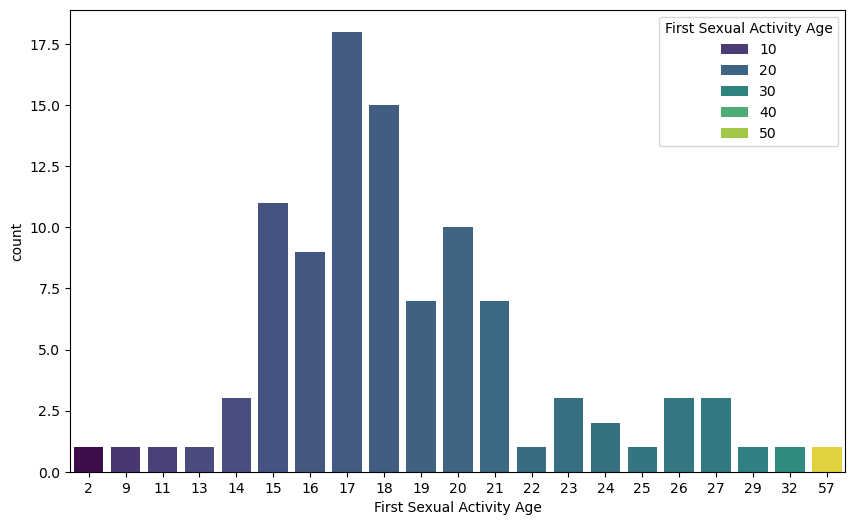

In [215]:
# First Sexual Intercourse Age
plt.figure(figsize=(10, 6))
sns.countplot(data=cerv_df, x='First Sexual Activity Age', palette='viridis', hue='First Sexual Activity Age');

First sexual activity age:
- similar to the age feature, the same preprocessing will be done

## Categorical Analysis

In [216]:
cerv_df.head()

,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN


In [217]:
# HPV Test Result
cerv_df['HPV Test Result'].value_counts()

HPV Test Result
NEGATIVE      47
POSITIVE      46
POSITIVE\n     6
NEGAGTIVE      1
Name: count, dtype: int64

HPV Test Result:

Incorrect spelling of positive and negative

To do: rename instances

In [218]:
cerv_df['HPV Test Result'] = cerv_df['HPV Test Result'].replace({'NEGAGTIVE': 'NEGATIVE' , 'POSITIVE\n': 'POSITIVE'})
cerv_df['HPV Test Result'].value_counts()

HPV Test Result
POSITIVE    52
NEGATIVE    48
Name: count, dtype: int64

The positive and negative HPV results are balanced.

In [219]:
# smoking status
cerv_df['Smoking Status'].value_counts()

Smoking Status
N    60
Y    40
Name: count, dtype: int64

In [220]:
# STDs History
cerv_df['STDs History'].value_counts()


STDs History
N    52
Y    48
Name: count, dtype: int64

In [221]:
# Pap Smear Result
cerv_df['Pap Smear Result'].value_counts()

Pap Smear Result
N    65
Y    35
Name: count, dtype: int64

In [222]:
cerv_df['Screening Type Last'].value_counts()

Screening Type Last
PAP SMEAR    39
VIA          31
HPV DNA      30
Name: count, dtype: int64

Screening Type Last:
- PAP SMEAR
- VIA - highly recommended in low resource settings
- HPV DNA

In [223]:
# regions
cerv_df['Region'].value_counts()

Region
Embu         14
Kericho      11
Mombasa      10
Kitale        9
Loitoktok     9
Kakamega      8
Machakos      7
Mombasa       5
Moi           5
Pumwani       4
Pumwani       3
Kitale        3
Machakos      2
Garissa       2
Garissa       2
Moi           2
Kericho       2
Kakamega      1
NAKURU        1
Name: count, dtype: int64

In [224]:
# recommended action
cerv_df['Recommended Action'].value_counts()

Recommended Action
REPEAT PAP SMEAR IN 3 YEARS                                 25
FOR COLPOSCOPY BIOPSY, CYTOLOGY                             11
FOR PAP SMEAR                                                9
FOR HPV VACCINE AND SEXUAL EDUCATION                         7
FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS                 7
FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS                5
REPEAT PAP SMEAR IN 3 YEARS                                  5
FOR COLPOSCOPY BIOPSY, CYTOLOGY                              5
FOR COLPOSCOPY BIOSPY, CYTOLOGY                              4
FOR COLOSCOPY BIOSY, CYTOLOGY                                3
REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE              2
FOR HPV VACCINATION AND SEXUAL EDUCATION                     2
FOR COLPOSCOPY CYTOLOGY AND BIOPSY                           1
FOR BIOPSY AND CYTOLOGY WITH TAH NOT RECOMMENDED             1
FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION              1
FOR COLPOSCOPY BIOSY, CYTOLOGY+/- TA

## Data Cleaning

In [225]:
cerv_df.head()

,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN


In [226]:
# drop unnecessary columns
cerv_df = cerv_df.drop(columns=['Unnamed: 12', 'Patient ID'], axis=1)
cerv_df.head()

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION


In [227]:
# drop the outlier in first sexual activity age
cerv_df_outlier = cerv_df[cerv_df['First Sexual Activity Age'] <= 2]
cerv_df_outlier

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
86,19,2,2,POSITIVE,Y,N,N,Kitale,Y,HPV DNA,"FOR COLOSCOPY BIOSY, CYTOLOGY"


In [228]:
cerv_df = cerv_df.drop(cerv_df[cerv_df['First Sexual Activity Age'] <= 2].index)
cerv_df

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
...,...,...,...,...,...,...,...,...,...,...,...
95,31,4,16,POSITIVE,Y,Y,N,Machakos,N,PAP SMEAR,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"
96,35,5,11,NEGATIVE,N,Y,N,Mombasa,N,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS
97,35,1,18,POSITIVE,N,Y,N,Kericho,N,HPV DNA,FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS
98,31,1,20,POSITIVE,Y,Y,N,Embu,Y,HPV DNA,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"


## Risk Assessment

In [229]:
cerv_df

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
...,...,...,...,...,...,...,...,...,...,...,...
95,31,4,16,POSITIVE,Y,Y,N,Machakos,N,PAP SMEAR,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"
96,35,5,11,NEGATIVE,N,Y,N,Mombasa,N,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS
97,35,1,18,POSITIVE,N,Y,N,Kericho,N,HPV DNA,FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS
98,31,1,20,POSITIVE,Y,Y,N,Embu,Y,HPV DNA,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"


In [230]:
cerv_risk_attr = cerv_df.drop(columns=['HPV Test Result', 'Pap Smear Result', 'Recommended Action', 'Region', 'Screening Type Last', 'Insrance Covered'], axis=1)
cerv_risk_attr.head()

,Age,Sexual Partners,First Sexual Activity Age,Smoking Status,STDs History
0,18,4,15,N,Y
1,15,1,14,Y,Y
2,34,1,9,N,Y
3,52,5,16,Y,N
4,46,3,21,N,N


### Feature Engineering

In [255]:
cerv_risk_attr['Years_Sexually_Active'] = cerv_risk_attr['Age'] - cerv_risk_attr['First Sexual Activity Age']

# Map categorical columns to numeric
smoking_map = {'N': 0, 'Y': 1}
stds_map = {'N': 0, 'Y': 1}

cerv_risk_attr['Smoking_Status_Num'] = cerv_risk_attr['Smoking Status'].map(smoking_map)
cerv_risk_attr['STDs_History_Num'] = cerv_risk_attr['STDs History'].map(stds_map)

cerv_risk_attr['Risk_Score'] = (
    cerv_risk_attr['Sexual Partners'] / 5 +
    (cerv_risk_attr['Years_Sexually_Active'] / 30) +
    cerv_risk_attr['Smoking_Status_Num'] +
    cerv_risk_attr['STDs_History_Num']
)

In [256]:
# smokes and has stds
cerv_risk_attr['Smokes_and_Has_STDs'] = cerv_risk_attr['Smoking_Status_Num'] * cerv_risk_attr['STDs_History_Num']

# sexual partner and years active
cerv_risk_attr['Sexual_Partner_and_Years_Active'] = cerv_risk_attr['Sexual Partners'] * cerv_risk_attr['Years_Sexually_Active']

In [257]:
# non linear transformation
cerv_risk_attr['Log_Sexual_Partners'] = np.log1p(cerv_risk_attr['Sexual Partners'])
cerv_risk_attr['Years_Sexually_Active_Squared'] = cerv_risk_attr['Years_Sexually_Active'] ** 2

In [258]:
# bining age
cerv_risk_attr['Age_Group'] = pd.cut(cerv_risk_attr['Age'], bins=[0, 25, 35, 50, 100], labels=['<25', '25-35', '36-50', '50+'])

In [259]:
cerv_risk_attr.head(20)

,Age,Sexual Partners,First Sexual Activity Age,Smoking Status,STDs History,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,...,Years_Sexually_Active_Squared,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Cluster,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Age_Group_nan,Age_Group
0,18.0,4.0,15.0,N,Y,3.0,0.0,1.0,1.900000,0.0,...,9.0,0.0,0.0,1.0,1,0.0,0.0,1.0,0.0,<25
1,15.0,1.0,14.0,Y,Y,1.0,1.0,1.0,2.233333,1.0,...,1.0,0.0,0.0,1.0,2,0.0,0.0,1.0,0.0,<25
2,34.0,1.0,9.0,N,Y,25.0,0.0,1.0,2.033333,0.0,...,625.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,25-35
3,52.0,5.0,16.0,Y,N,36.0,1.0,0.0,3.200000,0.0,...,1296.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,50+
4,46.0,3.0,21.0,N,N,25.0,0.0,0.0,1.433333,0.0,...,625.0,1.0,0.0,0.0,1,1.0,0.0,0.0,0.0,36-50
5,42.0,3.0,23.0,N,N,19.0,0.0,0.0,1.233333,0.0,...,361.0,1.0,0.0,0.0,1,1.0,0.0,0.0,0.0,36-50
6,51.0,3.0,27.0,Y,Y,24.0,1.0,1.0,3.400000,1.0,...,576.0,0.0,1.0,0.0,2,0.0,1.0,0.0,0.0,50+
7,26.0,1.0,26.0,Y,N,0.0,1.0,0.0,1.200000,0.0,...,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,25-35
8,49.0,1.0,20.0,Y,Y,29.0,1.0,1.0,3.166667,1.0,...,841.0,1.0,0.0,0.0,2,1.0,0.0,0.0,0.0,36-50
9,89.0,3.0,15.0,N,Y,74.0,0.0,1.0,4.066667,0.0,...,5476.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,50+


In [260]:
cerv_risk_attr['Risk_Score'] = MinMaxScaler().fit_transform(cerv_risk_attr[['Risk_Score']])
cerv_risk_attr

,Age,Sexual Partners,First Sexual Activity Age,Smoking Status,STDs History,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,...,Years_Sexually_Active_Squared,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Cluster,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Age_Group_nan,Age_Group
0,18.0,4.0,15.0,N,Y,3.0,0.0,1.0,0.424779,0.0,...,9.0,0.0,0.0,1.0,1,0.0,0.0,1.0,0.0,<25
1,15.0,1.0,14.0,Y,Y,1.0,1.0,1.0,0.513274,1.0,...,1.0,0.0,0.0,1.0,2,0.0,0.0,1.0,0.0,<25
2,34.0,1.0,9.0,N,Y,25.0,0.0,1.0,0.460177,0.0,...,625.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,25-35
3,52.0,5.0,16.0,Y,N,36.0,1.0,0.0,0.769912,0.0,...,1296.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,50+
4,46.0,3.0,21.0,N,N,25.0,0.0,0.0,0.300885,0.0,...,625.0,1.0,0.0,0.0,1,1.0,0.0,0.0,0.0,36-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,35.0,5.0,11.0,Y,N,24.0,1.0,0.0,0.663717,0.0,...,576.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,25-35
97,35.0,1.0,18.0,Y,N,17.0,1.0,0.0,0.389381,0.0,...,289.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,25-35
98,31.0,1.0,20.0,Y,N,11.0,1.0,0.0,0.336283,0.0,...,121.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,25-35
99,59.0,6.0,22.0,N,Y,37.0,0.0,1.0,0.831858,0.0,...,1369.0,NaN,NaN,NaN,0,0.0,0.0,0.0,1.0,50+


In [261]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
cerv_risk_attr_encoded = ohe.fit_transform(cerv_risk_attr[['Age_Group']])
cerv_risk_attr_encoded_df = pd.DataFrame(cerv_risk_attr_encoded, columns=ohe.get_feature_names_out(['Age_Group']))
cerv_risk_attr = pd.concat([cerv_risk_attr, cerv_risk_attr_encoded_df], axis=1)
cerv_risk_attr = cerv_risk_attr.drop(columns=['Age_Group'], axis=1)
cerv_risk_attr.head()

,Age,Sexual Partners,First Sexual Activity Age,Smoking Status,STDs History,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,...,Age_Group_<25,Cluster,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Age_Group_nan,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Age_Group_nan
0,18.0,4.0,15.0,N,Y,3.0,0.0,1.0,0.424779,0.0,...,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,15.0,1.0,14.0,Y,Y,1.0,1.0,1.0,0.513274,1.0,...,1.0,2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,34.0,1.0,9.0,N,Y,25.0,0.0,1.0,0.460177,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52.0,5.0,16.0,Y,N,36.0,1.0,0.0,0.769912,0.0,...,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,46.0,3.0,21.0,N,N,25.0,0.0,0.0,0.300885,0.0,...,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Cluster with Engineered Features + Raw features

In [262]:
X = cerv_risk_attr[['Smoking_Status_Num', 'STDs_History_Num', 'Risk_Score', 'Smokes_and_Has_STDs', 'Sexual_Partner_and_Years_Active', 'Log_Sexual_Partners', 'Years_Sexually_Active_Squared', 'Age_Group_36-50', 'Age_Group_50+', 'Age_Group_<25']].values

X_scaled = StandardScaler().fit_transform(X)

In [263]:
# Fill NaNs in X_scaled with column means before clustering
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_scaled_no_nan = imputer.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled_no_nan)
cerv_risk_attr['Cluster'] = clusters

In [264]:
cerv_risk_attr

,Age,Sexual Partners,First Sexual Activity Age,Smoking Status,STDs History,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,...,Age_Group_<25,Cluster,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Age_Group_nan,Age_Group_36-50,Age_Group_50+,Age_Group_<25,Age_Group_nan
0,18.0,4.0,15.0,N,Y,3.0,0.0,1.0,0.424779,0.0,...,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,15.0,1.0,14.0,Y,Y,1.0,1.0,1.0,0.513274,1.0,...,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,34.0,1.0,9.0,N,Y,25.0,0.0,1.0,0.460177,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52.0,5.0,16.0,Y,N,36.0,1.0,0.0,0.769912,0.0,...,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,46.0,3.0,21.0,N,N,25.0,0.0,0.0,0.300885,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,35.0,5.0,11.0,Y,N,24.0,1.0,0.0,0.663717,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,35.0,1.0,18.0,Y,N,17.0,1.0,0.0,0.389381,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,31.0,1.0,20.0,Y,N,11.0,1.0,0.0,0.336283,0.0,...,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
99,59.0,6.0,22.0,N,Y,37.0,0.0,1.0,0.831858,0.0,...,NaN,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [265]:
sil_score = silhouette_score(X_scaled_no_nan, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.286


In [266]:
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled_no_nan)
    score = silhouette_score(X_scaled_no_nan, kmeans.labels_)
    print(f"k={k}: Silhouette Score = {score:.3f}")

k=2: Silhouette Score = 0.271
k=3: Silhouette Score = 0.286
k=4: Silhouette Score = 0.339
k=5: Silhouette Score = 0.422
k=6: Silhouette Score = 0.424


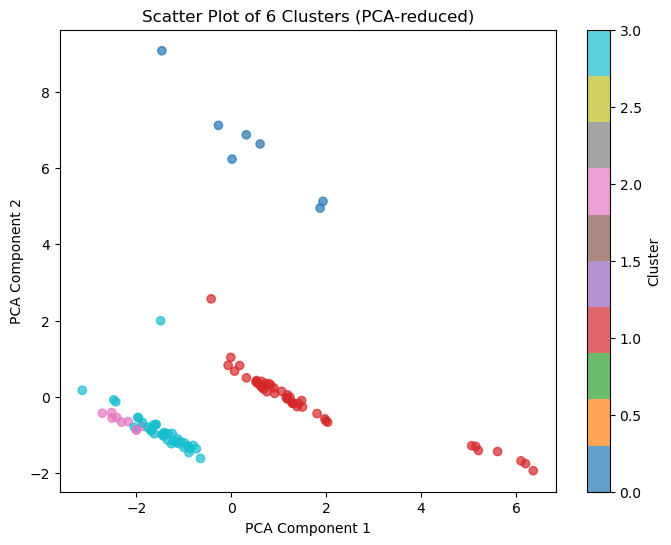

In [269]:
# Fit KMeans with 6 clusters
kmeans_6 = KMeans(n_clusters=4, random_state=42)
clusters_6 = kmeans_6.fit_predict(X_scaled_no_nan)

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_no_nan)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_6, cmap='tab10', alpha=0.7)
plt.title('Scatter Plot of 6 Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()